In [6]:
import copy
from datetime import datetime
import itertools
import os
import pickle
import sys
import time
# sys.path.append('/home/diego/Dropbox/hold_noise/mpl_styles/')
sys.path.append('/home/diego/python/generative-glm/experiments/')

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import loadmat
import torch
from torch.optim import Adam

from experiments.utils.plot import plot_layout_fit
from experiments.utils.kernels import *
from gglm.glm.mmdglm import MMDGLM
from gglm.glm.torchglm import TorchGLM
from gglm.utils import shift_array
from gglm.metrics import bernoulli_log_likelihood_poisson_process, MMD, time_rescale_transform
from kernel.fun import KernelFun
from kernel.rect import KernelRect
from kernel.values import KernelBasisValues
from sptr.sptr import SpikeTrain
from utils import after_metrics, fun_metrics_mmd

# from signals import auto_covariance
from signals import raw_autocorrelation

import myplt

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
from nips import *
for key, val in paper.items():
    mpl.rcParams[key] = val
palette = dict(d='C0', ml='C2', mmd='C1')

server_name = os.uname()[1]
print(server_name)
from IPython.display import Javascript
Javascript('document.title="{}"'.format(server_name))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
yoda


<IPython.core.display.Javascript object>

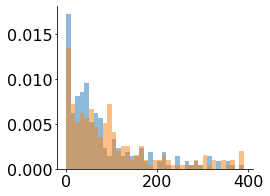

In [2]:
path = "./huk_p110509b_dots.h5"
f = h5py.File(path, "r")

mask_spikes = np.array(np.stack((f['spk']), axis=1), dtype=bool)
t = np.arange(0, mask_spikes.shape[0], 1)
dt = 1

files_folder = '/home/diego/storage/projects/generative-glm/experiments/figure4/'

idx_train = np.arange(100, 200, 2)
idx_val = idx_train + 1

# idx = np.random.choice(mask_spikes.shape[1], size=n_train + n_val, replace=False)

st = SpikeTrain(t, mask_spikes)
mask_spikes_train = mask_spikes[:, idx_train]
# mask_spikes_train = mask_spikes[:, offset:offset + n_train]

n_spk_train = np.sum(mask_spikes_train)
fr_train = np.mean(np.sum(mask_spikes_train, 0) / (t[-1] - t[0] + t[1]) * 1000)
fr2_train = np.mean((np.sum(mask_spikes_train, 0) / (t[-1] - t[0] + t[1]) * 1000)**2)
nll_pois_proc_train = -bernoulli_log_likelihood_poisson_process(mask_spikes_train)
autocov_train = np.mean(raw_autocorrelation(mask_spikes_train, biased=False), 1)
st_train = SpikeTrain(t, mask_spikes_train)
isi_train = st_train.isi_distribution()
mean_isi_train = np.mean(isi_train)

mask_spikes_val = mask_spikes[:, idx_val]
n_spk_val = np.sum(mask_spikes_val)
fr_val = np.mean(np.sum(mask_spikes_val, 0) / (t[-1] - t[0] + t[1]) * 1000)
nll_pois_proc_val = -bernoulli_log_likelihood_poisson_process(mask_spikes_val)
autocov_val = np.mean(raw_autocorrelation(mask_spikes_val, biased=False), 1)

st_val = SpikeTrain(t, mask_spikes_val)
isi_val = st_val.isi_distribution()
mean_isi_val = np.mean(isi_val)

bins_isi = np.arange(0, 400, 10)
fig, ax = plt.subplots()
ax.hist(isi_train, density=True, alpha=0.5, bins=bins_isi);
ax.hist(isi_val, density=True, alpha=0.5, bins=bins_isi);

argf_autocorr = 200

## load ml

In [3]:
files_folder = '/home/diego/storage/projects/generative-glm/experiments/figure4/'
with open(files_folder + 'mln5.pk', "rb") as fit_file:
    dic_ml = pickle.load(fit_file)
eta_ml = KernelBasisValues(dic_ml['basis'], [0, dic_ml['basis'].shape[0]], 1, coefs=dic_ml['eta_coefs'])
glm_ml = TorchGLM(u0=dic_ml['u0_ml'], eta=eta_ml)
nll_normed_train_ml = dic_ml['nll_normed_train_ml']
nll_normed_val_ml = dic_ml['nll_normed_val_ml']
bins_ks = dic_ml['bins_ks']
t_ker = np.arange(0, eta_ml.basis_values.shape[0], 1) * dt

r_train_dc_ml, r_val_dc_ml, r_fr_ml, mask_spikes_fr_ml = dic_ml['r_train_dc_ml'], dic_ml['r_val_dc_ml'], dic_ml['r_fr_ml'], dic_ml['mask_spikes_fr_ml']

st_fr_ml = SpikeTrain(st_val.t, mask_spikes_fr_ml)
isi_fr_ml = st_fr_ml.isi_distribution()
mean_isi_fr_ml = np.mean(isi_fr_ml)
mean_r_fr_ml = np.mean(r_fr_ml, 1)
sum_r_fr_ml = np.sum(r_fr_ml, 1)
autocov_ml = np.mean(raw_autocorrelation(mask_spikes_fr_ml, biased=False), 1)

z_ml_train, ks_ml_train = time_rescale_transform(dt, st_train.mask, r_train_dc_ml)
values, bins_ks = np.histogram(np.concatenate(z_ml_train), bins=bins_ks)
z_cum_ml_train = np.append(0., np.cumsum(values) / np.sum(values))

z_ml_val, ks_ml_val = time_rescale_transform(dt, st_val.mask, r_val_dc_ml)
values, _ = np.histogram(np.concatenate(z_ml_val), bins=bins_ks)
z_cum_ml_val = np.append(0., np.cumsum(values) / np.sum(values))

### MMD

In [4]:
kernel_kwargs = None
n_samples = 8000
# phi, kernel, lam_mmd, biased, lr, clip = None, ker_fr, 1e1, False, 1e-3, 1e0 # hard to get it to match fr
# phi, kernel, lam_mmd, biased, lr, clip, sd2 = None, ker_expfr, 1e4, True, 1e-2, 5e-1, 1e7 # works good with high nbumber of samples
# phi, kernel, lam_mmd, biased, lr, clip, n_batch_fr, num_epochs, initialization, kernel_kwargs = None, ker_sch_heavi, 1e0, False, 2e-3, None, 800, 800, 'zero', dict(sd2s=[1e6, 1e4, 1e2])
# phi, kernel, lam_mmd, biased, lr, clip, n_batch_fr, num_epochs, initialization, kernel_kwargs = None, ker_expfr_sum, 1e0, False, 5e-3, None, 800, 150, 'zero', dict(sd2s=[1e6, 1e4, 1e2, 1e1])
phi, kernel, lam_mmd, biased, lr, clip, n_batch_fr, num_epochs, initialization, kernel_kwargs = phi_autocov, None, 1e9, True, 1e-2, None, 800, 400, 'zero', dict(padding=250)

# phi, kernel, lam_mmd, biased, lr, clip, sd2, n_batch_fr = None, ker_expfr, 5e4, True, 1e-2, 5e-1, 1e7, 400 # works good with high nbumber of samples

# phi, kernel, lam_mmd, biased, lr, clip, n_batch_fr, num_epochs, initialization = phi_mean_fr, None, 3e3, True, 1e-2, None, 800, 2000, 'zero'

# phi, kernel, lam_mmd, biased, lr, clip, n_batch_fr, num_epochs, initialization = phi_cum, None, 1e0, True, 1e-2, None, 800, 120, 'zero'

# phi, kernel, lam_mmd, biased, lr, clip, n_batch_fr, num_epochs, initialization = phi_var_fr, None, 5e-1, True, 5e-2, 5e-1, 800, 100, 'zero'

# phi, kernel, lam_mmd, biased, lr, clip, sd2, n_batch_fr, num_epochs = phi_mean_fr, None, 1e0, True, 1e-2, None, 1e7, 800, 600

# phi, kernel, lam_mmd, biased, lr, clip, sd2, n_batch_fr, num_epochs = phi_mean_fr, None, 1e0, False, 1e-2, None, 1e7, 3200, 600

# seems like the firing rate match is small enough than no progress is made. true mean 3, samples mean 6
# phi, kernel, lam_mmd, biased, lr, clip, n_batch_fr, num_epochs = phi_mean_fr, None, 5e2, True, 1e-2, None, 24000, 800

# phi, kernel, lam_mmd, biased, lr, clip, n_batch_fr, num_epochs = phi_var_fr, None, 5e-3, True, 1e-2, None, 24000, 400

# phi, kernel, lam_mmd, biased, lr, clip, n_batch_fr, num_epochs = None, ker_var_fr, 1e0, True, 1e-2, None, 800, 100

beta0, beta1 = 0.95, 0.99
# beta0, beta1 = 0, 0
n_metrics = 1
log_likelihood = True
control_variates = False

dtime = datetime.now()
dtime = str(dtime.year) + '/' + str(dtime.month) + '/' + str(dtime.day) + '-' + str(dtime.hour) + ':' + str(dtime.minute) + ':' + str(dtime.second)

time0 = time.time()
u00 = glm_ml.u0
eta0 = glm_ml.eta.copy()


# eta0 = KernelBasisValues.orthogonalized_raised_cosines(dt, 100, 5, 5e1, a=1)





if initialization == 'zero':
    eta0.coefs = eta0.coefs * 0

mmdglm = MMDGLM(u0=u00, eta=eta0)
optim = Adam(mmdglm.parameters(), lr=lr, betas=(beta0, beta1), amsgrad=False)

loss_mmd, nll_train, metrics_mmd = mmdglm.train(t, torch.from_numpy(mask_spikes_train), phi=phi, kernel=kernel, 
                                                log_likelihood=log_likelihood,
                                               n_batch_fr=n_batch_fr, lam_mmd=lam_mmd, biased=biased, kernel_kwargs=kernel_kwargs, optim=optim, clip=clip, 
                                                num_epochs=num_epochs, verbose=True, metrics=fun_metrics_mmd, n_metrics=n_metrics, control_variates=control_variates)

loss_mmd, nll_train = np.array(loss_mmd), np.array(nll_train)
nll_normed_train_mmd = (nll_train - nll_pois_proc_train) / np.log(2) / n_spk_train
metrics_mmd['mmd'] = np.array(metrics_mmd['mmd'])
iterations_mmd = np.arange(1, num_epochs + 1, 1)

_, r_dc_mmd_train = mmdglm.sample_conditioned(st_train.t, st_train.mask)
z_mmd_train, ks_mmd_train = time_rescale_transform(dt, st_train.mask, r_dc_mmd_train)
values, bins_ks = np.histogram(np.concatenate(z_mmd_train), bins=bins_ks)
z_cum_mmd_val = np.append(0., np.cumsum(values) / np.sum(values))

_, r_dc_mmd_val = mmdglm.sample_conditioned(st_val.t, st_val.mask)
_, r_fr_mmd, mask_spikes_fr_mmd = mmdglm.sample(st_val.t, shape=(n_samples,))
st_fr_mmd = SpikeTrain(st_train.t, mask_spikes_fr_mmd)
fr_mmd = np.sum(mask_spikes_fr_mmd, 0) / (dt * mask_spikes_fr_mmd.shape[0]) * 1000
print(np.max(fr_mmd), np.mean(fr_mmd), np.mean(fr_mmd**2), np.std(fr_mmd))
print(np.std(np.sum(mask_spikes_train, 0) / (t[-1] - t[0] + t[1]) * 1000), np.mean((np.sum(mask_spikes_train, 0) / (t[-1] - t[0] + t[1]) * 1000)**2))
isi_fr_mmd = st_fr_mmd.isi_distribution()
mean_isi_fr_mmd = np.mean(isi_fr_mmd)
autocov_mmd = np.mean(raw_autocorrelation(mask_spikes_fr_mmd, biased=False), 1)
rmse_autocov = np.sqrt(np.mean((autocov_mmd - autocov_train)**2))
nll_val_mmd = -(np.sum(np.log(1 - np.exp(-dt * r_dc_mmd_val[st_val.mask]) + 1e-24) ) - \
            dt * np.sum(r_dc_mmd_val[~st_val.mask]))
nll_normed_val_mmd = (nll_val_mmd - nll_pois_proc_val) / np.log(2) / n_spk_val
z_mmd_val, ks_mmd_val = time_rescale_transform(dt, st_val.mask, r_dc_mmd_val)
values, bins_ks = np.histogram(np.concatenate(z_mmd_val), bins=bins_ks)
z_cum_mmd_val = np.append(0., np.cumsum(values) / np.sum(values))

r_dc_mmd_train, r_fr_mmd = r_dc_mmd_train * 1000, r_fr_mmd * 1000
r_dc_mmd_val = r_dc_mmd_val * 1000

time1 = time.time()
etime = (time1 - time0) / 60
print('\n', 'took', time1 - time0, 'seconds', (time1 - time0) / 60, 'minutes')

mmd_mmd = MMD(t, torch.from_numpy(st_train.mask), torch.from_numpy(mask_spikes_fr_mmd), phi=phi, kernel=kernel, biased=biased).item()

 epoch 399 of 400 loss 7887.5069641223698217.355371900826444 4.988326446280993 30.177327368349157 2.30085345767235
3.3559825198573177 32.07431186394373

 took 118.70784211158752 seconds 1.9784640351931253 minutes


In [7]:
mmdglm_after = MMDGLM(u0=mmdglm.u0, eta=mmdglm.eta.copy())

_loss_mmd, _nll_train, metrics_after = mmdglm_after.train(t, torch.from_numpy(mask_spikes_train), phi=phi, kernel=kernel, 
                                                log_likelihood=False, n_batch_fr=n_batch_fr, lam_mmd=lam_mmd, biased=biased, 
                                                kernel_kwargs=kernel_kwargs, optim=torch.optim.SGD(mmdglm_after.parameters(), lr=0),
                                               num_epochs=50, verbose=True, metrics=after_metrics, n_metrics=1, control_variates=False)

mmd_mean = np.mean(metrics_after['mmd'])
mmd_sd = np.std(metrics_after['mmd'])
params_grad = np.concatenate((np.array(metrics_after['b_grad'])[:, None], np.array(metrics_after['eta_coefs_grad'])), axis=1)
params_grad_mean = np.mean(params_grad, 0)
params_grad_cov = np.cov(params_grad.T)

fr_mean_mean, fr_mean_sd = np.mean(metrics_after['mu_fr']), np.std(metrics_after['mu_fr'])
fr_max_mean, fr_max_sd = np.mean(metrics_after['fr_max']), np.std(metrics_after['fr_max'])
print('\nmmd', mmd_mean, mmd_sd)

 epoch 49 of 50 loss 5771.0690002372
mmd 1.7132464056416897e-07 6.139815836675828e-09


In [ ]:
for key, val in metrics_mmd.items():
    metrics_mmd[key] = np.array(val)

if phi is not None:
    ker_name = phi.__name__
else:
    ker_name = kernel.__name__
    
title = "k(r, r')=" + ker_name + '  optim=' + str(optim.__class__.__name__) + '  lr=' + str(lr) \
     + '  epochs=' + str(num_epochs) + \
       '  lam_mmd=' + str(lam_mmd) + '  n_fr=' + str(n_batch_fr) + '  biased=' + str(biased)

if nll_train is None or len(nll_train)==0:
    nll_train = np.zeros(len(iterations_mmd))
    nll_normed_train_mmd = np.zeros(len(iterations_mmd))

# if np.mean(loss_mmd - nll_train) > 0:
#     ax3.plot(loss_mmd - nll_train)
# else:
#     ax3.plot(-(loss_mmd - nll_train))
# ax3.set_ylabel('lam*mmd')
# ax3.set_yscale('log')
# ax4.plot(metrics_mmd['b_grad_norm'])
# ax4.set_yscale('log')
# ax5.plot(metrics_mmd['eta_coefs_grad_norm'])
# ax5.set_yscale('log')

# ncols = 4
# r1, r2 = 2, 1
# nrows = 2 * r1 + 3 * r2

# fig, (ax00, ax01, ax02, ax03, ax10, ax11, ax20, ax21, ax30, ax40, ax41, ax42, ax43) = plot_layout()

fig, (axloss, axnlli, axmmdi, axextra, axd, axfr, axeta, axisi, axpsth, axnll, axmmd, axac) = plot_layout_fit()

axloss.plot(loss_mmd)
axloss.set_ylim(np.percentile(loss_mmd, [2.5, 97.5]) * np.array([0.95, 1.05]))

axnlli.plot(nll_normed_train_mmd)

mmdi = loss_mmd - nll_train
axmmdi.plot(mmdi)
axmmdi.set_ylim(np.percentile(mmdi, [2.5, 97.5]) * np.array([0.95, 1.05]))

axextra.plot(metrics_mmd['mmd'])
axextra.set_ylim(np.percentile(metrics_mmd['mmd'], [2.5, 97.5]) * np.array([0.95, 1.05]))

# fig.suptitle(title, fontsize=12, y=0.92)

# ax00.plot(iterations_mmd, nll_normed_train_mmd, '-', label='train', color=palette['mmd'])
# ax00.plot([iterations_mmd[0], iterations_mmd[-1]], [nll_normed_train_mmd[0], nll_normed_train_mmd[0]], '-', 
#           label='ML-GLM', color=palette['ml'])
# ax00.spines['right'].set_visible(True)
# ax00.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# # ax00.legend()
# myplt.set_labels(ax00, xlabel='iterations', ylabel='neg log-likelihood (bits/spk)')

# mm = 100
# print(np.mean(metrics_mmd['mmd'][-mm:]), np.std(metrics_mmd['mmd'][-mm:]))
# ax01.plot(iterations_mmd[::n_metrics], metrics_mmd['mmd'], label='MMD-GLM', color=palette['mmd'])
# ax01.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# yf = np.median(metrics_mmd['mmd'][-10:] * 2)
# ax01.set_yscale('log')
# # ax01.set_ylim(-1e2, yf)
# myplt.set_labels(ax01, xlabel='iterations', ylabel='MMD')

glm_ml.eta.plot(t=t_ker, ax=axeta, exp_values=True, label='ML-GLM', color=palette['ml'])
mmdglm.eta.plot(t=t_ker, ax=axeta, exp_values=True, label='MMD-GLM', color=palette['mmd'])

# ax11.hist(isi_train, density=True, alpha=0.5, color=palette['d'], label='data', bins=bins_isi)
# ax11.legend()
# y1 = ax11.get_ylim()[1] / 2
# ax11.plot([mean_isi_train, mean_isi_train], [0, y1], '-', color=palette['d'])
# ax11.set_ylabel('pdf(isi)')
# ax11.tick_params(axis='both', labelbottom=False)

# # ax21.hist(isi_fr_mmd, density=True, alpha=0.5, color=palette['mmd'], label='MMD-GLM', bins=bins)
# # ax21.plot([mean_isi_fr_mmd, mean_isi_fr_mmd], [0, y1], '-', color=palette['mmd'])
# ax21.hist(isi_fr_mmd, density=True, alpha=0.5, color=palette['mmd'], label='MMD-GLM', bins=bins_isi)
# ax21.plot([mean_isi_fr_mmd, mean_isi_fr_mmd], [0, y1], '-', color=palette['mmd'])
# myplt.set_labels(ax21, xlabel='time (ms)', ylabel='pdf(isi)')


st_train.plot(ax=axd, ms=0.7, color=palette['d'])

st_fr_mmd.sweeps(np.arange(st_train.mask.shape[1])).plot(ax=axfr, ms=0.7, color=palette['mmd'])

# ax30.plot(t, np.mean(r_dc_mmd_val, 1), color=palette['d'], label='dc')
# ax30.plot(t, np.mean(r_fr_mmd, 1), color=palette['mmd'], label='fr')
# # ax30.plot(t_long, np.mean(r_train_dc_ml, 1), color=palette['ml'], label='ML-FR')

# ax30.legend()
# myplt.set_labels(ax30, xlabel='time (ms)', ylabel='CI (Hz)')

# axmmd.bar(0, -nll_normed_train_mmd[-1], alpha=0.5, color=palette['mmd'], label='CIMMD-GLM')
# axmmd.bar(1, -nll_normed_train_ml[-1], alpha=0.5, color=palette['ml'], label='ML-GLM')

axmmd.bar([0, 1], [-nll_normed_train_mmd[-1], -nll_normed_train_ml[-1]])

# ax40.bar(2, -nll_normed_val_mmd, alpha=0.5, color=palette['mmd'], label='CIMMD-GLM')
# ax40.bar(3, -nll_normed_val_ml[-1], alpha=0.5, color=palette['ml'], label='ML-GLM')
# # ax40.legend()
# ax40.set_ylabel('log-likelihood (bits/spk)')
# ax40.set_xticks([0, 1])
# ax40.set_xticklabels(['CIMMD', 'ML'])

# # ax40.set_ylabel('log-likelihood (bits/spk)')

axisi.hist(isi_val, density=True, alpha=1, color=palette['d'], histtype='step', label='data', bins=bins_isi)
axisi.hist(isi_fr_ml, density=True, alpha=1, color=palette['ml'], histtype='step', label='ML-GLM', bins=bins_isi)
axisi.hist(isi_fr_mmd, density=True, alpha=1, color=palette['mmd'], histtype='step', label='MMD-GLM', bins=bins_isi)

axac.plot(autocov_val[1:argf_autocorr], color=palette['d'], label='data')
# axac.plot(autocov_ml[:argf_autocorr], color=palette['ml'], label='ML-GLM')
axac.plot(autocov_mmd[1:argf_autocorr], color=palette['mmd'], label='MMD-GLM')

In [28]:
np.max(autocov_val[10:]) * 1.05

0.0009545454545454473

In [55]:
list_files = os.listdir('/home/diego/storage/projects/generative-glm/experiments/figure4/')

file_name = 'mmd_' + ker_name + '_' + 'lammmd' + str(lam_mmd) + 'biased' + str(biased) +  \
           '_epochs' + str(num_epochs) + '_' + 'lr' + str(lr)
ii = 1
while file_name + '_' + str(ii) + '.pk' in list_files:
    ii += 1
file_name = file_name + '_' + str(ii) + '.pk'


# fig.savefig('/home/diego/storage/generative-glm/experiments/figure4/' + fig_name, transparent=True)

dic = dict(server=os.uname()[1], dtime=dtime, idx_train=idx_train, idx_val=idx_val, basis=basis, 
           u0_ml=glm_ml.u0, eta_coefs_ml=glm_ml.eta.coefs, ker_name=ker_name, 
           lam_mmd=lam_mmd, biased=biased, lr=lr, clip=clip, n_batch_fr=n_batch_fr, loss_mmd=loss_mmd, nll_train=nll_normed_train_mmd, 
           nll_normed_val_mmd=nll_normed_val_mmd, metrics_mmd=metrics_mmd, u0_mmd=mmdglm.u0, eta_coefs_mmd=mmdglm.eta.coefs)

path = '/home/diego/storage/projects/generative-glm/experiments/figure4/' + file_name
with open(path, "wb") as fit_file:
    pickle.dump(dic, fit_file)
    
# dic_df = dict(server=os.uname()[1], dtime=dtime, idx_train=idx_train, idx_val=idx_val, mmd_ker='score_function', ker_name=ker_name, n_basis=n, 
#               last_peak=last_peak, 
#                 lam_mmd=lam_mmd, biased=biased, lr=lr, clip=clip, n_batch_fr=n_batch_fr, loss_mmd=loss_mmd[-1], nll_train=nll_normed_train_mmd[-1], 
#               nll_normed_val_mmd=nll_normed_val_mmd, fr_mmd_m=np.mean(fr_mmd), fr_mmd_max=np.max(fr_mmd), mmd_mmd=mmd_mmd, 
#               u0=mmdglm.u0, eta_coefs=mmdglm.eta.coefs)

ker_kwargs = None if kernel_kwargs is None else list(kernel_kwargs.values())
dic_df = dict(file_name=file_name, server=os.uname()[1], dtime=dtime, idx_train=idx_train, idx_val=idx_val, mmd_ker='score_function', ker_name=ker_name, n_basis=n, 
              last_peak=last_peak, num_epochs=num_epochs, log_likelihood=log_likelihood, control_variates=control_variates, 
                lam_mmd=lam_mmd, biased=biased, lr=lr, beta0=beta0, beta1=beta1, clip=clip, n_batch_fr=n_batch_fr, etime=etime, loss_mmd=loss_mmd[-1], 
                nll_train=nll_train[-1], nll_normed_train=nll_normed_train_mmd[-1], 
              nll_normed_val_mmd=nll_normed_val_mmd, fr_mmd_m=np.mean(fr_mmd), fr_mmd_max=np.max(fr_mmd), mmd_mmd=mmd_mmd, 
              u0=mmdglm.u0, eta_coefs=mmdglm.eta.coefs, mmd_mean=mmd_mean, mmd_sd=mmd_sd, params_grad_mean=params_grad_mean, params_grad_cov=params_grad_cov, 
                fr_mean_mean=fr_mean_mean, fr_mean_sd=fr_mean_sd, fr_max_mean=fr_max_mean, fr_max_sd=fr_max_sd, initialization=initialization, 
              kernel_kwargs=ker_kwargs)

_df = pd.DataFrame(pd.Series(dic_df)).T

df = pd.read_json('./mmd_summary_new.json')
df = df.append(_df, ignore_index=True)
df.to_json('./mmd_summary_new.json', double_precision=15)

# df = pd.read_json('./mmd_summary.json')
# df = df.append(_df, ignore_index=True)
# df.to_json('./mmd_summary.json', double_precision=15)

In [38]:
# df['file_name'] = None
# df = df[['file_name'] + list(df.columns[:-1])]
# df.to_json('./mmd_summary_new.json', double_precision=15)

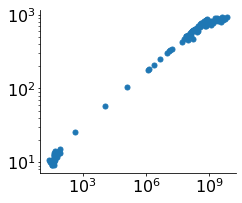

In [166]:
# # plt.figure()
# # # plt.plot(metrics_mmd['mu_fr'], metrics_mmd['max_fr'], 'o')
# # plt.plot(metrics_mmd['norm2_fr'], metrics_mmd['max_fr'], 'o')
# # # plt.plot(metrics_mmd['mmd'], metrics_mmd['max_fr'], 'o')
# # plt.yscale('log')
# # plt.xscale('log')
# plt.figure()
# plt.plot(metrics_mmd['min_fr'])
# plt.plot(metrics_mmd['mu_fr'])
# # plt.plot(metrics_mmd['max_fr'])
# plt.figure()
# # plt.plot(metrics_mmd['log_proba'][:, 3])
# # plt.plot(metrics_mmd['log_proba'][:, 0])
# # plt.plot(metrics_mmd['log_proba'][:, 2])
# plt.plot(metrics_mmd['log_proba'][:, 1])
# # plt.plot(metrics_mmd['mmd'] * 1e-7)
# # plt.plot(metrics_mmd['scores'][:, 1, 3])
# # plt.plot(metrics_mmd['mmd'], metrics_mmd['log_proba'][:, 3], 'o')
# fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(12, 4), ncols=4)
# ax1.plot(metrics_mmd['b'])
# ax2.plot(metrics_mmd['b_grad_norm'])
# ax3.plot(metrics_mmd['eta_coefs'])
# ax4.plot(metrics_mmd['eta_coefs_grad_norm'])
# # ax1.set_yscale('log')
# # ax2.plot(metrics_mmd['mean_dot'])
# # ax2.set_yscale('log')
# # ax3.plot(metrics_mmd['norm2_fr'], metrics_mmd['mean_dot'])
# fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12, 4), ncols=3)
# ax1.plot(metrics_mmd['norm2_fr'])
# ax1.set_yscale('log')
# ax2.plot(metrics_mmd['mean_dot'])
# ax2.set_yscale('log')
# ax3.plot(metrics_mmd['norm2_fr'], metrics_mmd['mean_dot'])

In [28]:
pars_mean_fr = list(itertools.product([2e3], [0], [0], [800], ['ml', 'zero']))
pars_mean_fr = pars_mean_fr * 2
# pars_var_fr = list(itertools.product([3e-2, 4e-2], [0], [0], [800], ['ml', 'zero']))
# pars_var_fr = pars_var_fr * 10
# pars_exp_fr = list(itertools.product([3e5, 5e5, 7e5], [0], [0, 0.999], ['ml', 'zero'], [1e3]))
# pars_exp_fr = pars_exp_fr * 5

for lam_mmd, beta0, beta1, n_batch_fr, initialization in pars_mean_fr:
    phi, kernel, biased, lr, clip, num_epochs, kernel_kwargs = phi_mean_fr, None, True, 5e-2, None, 1200, None
# for lam_mmd, beta0, beta1, n_batch_fr, initialization in pars_var_fr:
#     phi, kernel, biased, lr, clip, num_epochs, kernel_kwargs = phi_var_fr, None, True, 1e-2, None, 1200, None
# for lam_mmd, beta0, beta1, initialization, sd2 in pars_exp_fr:
#     phi, kernel, biased, lr, clip, n_batch_fr, num_epochs, kernel_kwargs = None, ker_expfr, False, 1e-2, None, 800, 1200, dict(sd2=sd2)

    kernel_kwargs = None

#     phi, kernel, lam_mmd, biased, lr, clip, n_batch_fr, num_epochs, initialization = phi_mean_fr, None, 2e3, True, 5e-2, 5e-1, 800, 600, 'zero'

    beta0, beta1 = 0, 0
    n_metrics = 5
    log_likelihood = True
    control_variates = False

    dtime = datetime.now()
    dtime = str(dtime.year) + '/' + str(dtime.month) + '/' + str(dtime.day) + '-' + str(dtime.hour) + ':' + str(dtime.minute) + ':' + str(dtime.second)

    time0 = time.time()
    u00 = glm_ml.u0
    eta0 = glm_ml.eta.copy()
    if initialization == 'zero':
        eta0.coefs = eta0.coefs * 0

    mmdglm = MMDGLM(u0=u00, eta=eta0)
    optim = Adam(mmdglm.parameters(), lr=lr, betas=(beta0, beta1), amsgrad=False)
    scheduler = None

    loss_mmd, nll_train, metrics_mmd = mmdglm.train(t, torch.from_numpy(mask_spikes_train), phi=phi, kernel=kernel, 
                                                    log_likelihood=log_likelihood,
                                                   n_batch_fr=n_batch_fr, lam_mmd=lam_mmd, biased=biased, kernel_kwargs=kernel_kwargs, optim=optim, clip=clip, 
                                                    num_epochs=num_epochs, scheduler=scheduler, 
                                                  verbose=True, metrics=fun_metrics_mmd, n_metrics=n_metrics, control_variates=control_variates)
    loss_mmd, nll_train = np.array(loss_mmd), np.array(nll_train)
    nll_normed_train_mmd = (nll_train - nll_pois_proc_train) / np.log(2) / n_spk_train
    metrics_mmd['mmd'] = np.array(metrics_mmd['mmd'])
    iterations_mmd = np.arange(1, num_epochs + 1, 1)

    _, r_dc_mmd_train = mmdglm.sample_conditioned(st_train.t, st_train.mask)
    z_mmd_train, ks_mmd_train = time_rescale_transform(dt, st_train.mask, r_dc_mmd_train)
    values, bins_ks = np.histogram(np.concatenate(z_mmd_train), bins=bins_ks)
    z_cum_mmd_val = np.append(0., np.cumsum(values) / np.sum(values))

    _, r_dc_mmd_val = mmdglm.sample_conditioned(st_val.t, st_val.mask)
    _, r_fr_mmd, mask_spikes_fr_mmd = mmdglm.sample(st_val.t, shape=(8000,))
    st_fr_mmd = SpikeTrain(st_train.t, mask_spikes_fr_mmd)
    fr_mmd = np.sum(mask_spikes_fr_mmd, 0) / (dt * mask_spikes_fr_mmd.shape[0]) * 1000
    print(np.max(fr_mmd), np.mean(fr_mmd), np.mean(fr_mmd**2), np.std(fr_mmd))
    print(np.std(np.sum(mask_spikes_train, 0) / (t[-1] - t[0] + t[1]) * 1000), np.mean((np.sum(mask_spikes_train, 0) / (t[-1] - t[0] + t[1]) * 1000)**2))
    isi_fr_mmd = st_fr_mmd.isi_distribution()
    mean_isi_fr_mmd = np.mean(isi_fr_mmd)
    autocov_mmd = np.mean(raw_autocorrelation(mask_spikes_fr_mmd, method='fft', 
                                               subtract_mean=False, stationary_signal=False, biased=False), 1)
    rmse_autocov = np.sqrt(np.mean((autocov_mmd - autocov_train)**2))
    nll_val_mmd = -(np.sum(np.log(1 - np.exp(-dt * r_dc_mmd_val[st_val.mask]) + 1e-24) ) - \
                dt * np.sum(r_dc_mmd_val[~st_val.mask]))
    nll_normed_val_mmd = (nll_val_mmd - nll_pois_proc_val) / np.log(2) / n_spk_val
    z_mmd_val, ks_mmd_val = time_rescale_transform(dt, st_val.mask, r_dc_mmd_val)
    values, bins_ks = np.histogram(np.concatenate(z_mmd_val), bins=bins_ks)
    z_cum_mmd_val = np.append(0., np.cumsum(values) / np.sum(values))

    r_dc_mmd_train, r_fr_mmd = r_dc_mmd_train * 1000, r_fr_mmd * 1000
    r_dc_mmd_val = r_dc_mmd_val * 1000

    time1 = time.time()
    etime = (time1 - time0) / 60
    print('\n', 'took', time1 - time0, 'seconds', (time1 - time0) / 60, 'minutes')

    mmd_mmd = MMD(t, torch.from_numpy(st_train.mask), torch.from_numpy(mask_spikes_fr_mmd), phi=phi, kernel=kernel, biased=biased).item()

    def after_metrics(model, t, mask_spikes, mask_spikes_fr):
        b_grad = model.b.grad.detach().item()
        eta_coefs_grad = model.eta_coefs.grad.detach().clone().numpy()
        T_train = t[-1] - t[0] + t[1]
        fr = np.sum(mask_spikes_fr.double().numpy(), 0) / T_train * 1000
        mu_fr = np.mean(fr) 
        fr_max = np.max(fr)
        return dict(b_grad=b_grad, eta_coefs_grad=eta_coefs_grad, mu_fr=mu_fr, fr_max=fr_max)

    mmdglm_after = MMDGLM(u0=mmdglm.u0, eta=mmdglm.eta.copy())

    _loss_mmd, _nll_train, metrics_after = mmdglm_after.train(t, torch.from_numpy(mask_spikes_train), phi=phi, kernel=kernel, 
                                                    log_likelihood=False, n_batch_fr=n_batch_fr, lam_mmd=lam_mmd, biased=biased, 
                                                    kernel_kwargs=kernel_kwargs, optim=torch.optim.SGD(mmdglm_after.parameters(), lr=0),
                                                   num_epochs=50, verbose=True, metrics=after_metrics, n_metrics=1, control_variates=False)

    mmd_mean = np.mean(metrics_after['mmd'])
    mmd_sd = np.std(metrics_after['mmd'])
    params_grad = np.concatenate((np.array(metrics_after['b_grad'])[:, None], np.array(metrics_after['eta_coefs_grad'])), axis=1)
    params_grad_mean = np.mean(params_grad, 0)
    params_grad_cov = np.cov(params_grad.T)

    fr_mean_mean, fr_mean_sd = np.mean(metrics_after['mu_fr']), np.std(metrics_after['mu_fr'])
    fr_max_mean, fr_max_sd = np.mean(metrics_after['fr_max']), np.std(metrics_after['fr_max'])
    print('\nmmd', mmd_mean, mmd_sd)

    for key, val in metrics_mmd.items():
        metrics_mmd[key] = np.array(val)

    if phi is not None:
        ker_name = phi.__name__
    else:
        ker_name = kernel.__name__

    title = "k(r, r')=" + ker_name + '  optim=' + str(optim.__class__.__name__) + '  lr=' + str(lr) \
         + '  epochs=' + str(num_epochs) + \
           '  lam_mmd=' + str(lam_mmd) + '  n_fr=' + str(n_batch_fr) + '  biased=' + str(biased)

    if nll_train is None or len(nll_train)==0:
        nll_train = np.zeros(len(iterations_mmd))
        nll_normed_train_mmd = np.zeros(len(iterations_mmd))

    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(figsize=(15, 3), ncols=5)
    ax1.plot(loss_mmd)
    ax1.set_ylabel('loss')
    ax2.plot(nll_train)
    ax2.set_ylabel('nll')
    if np.mean(loss_mmd - nll_train) > 0:
        ax3.plot(loss_mmd - nll_train)
    else:
        ax3.plot(-(loss_mmd - nll_train))
    ax3.set_ylabel('lam*mmd')
    ax3.set_yscale('log')
    # ax4.plot(metrics_mmd['b_grad_norm'])
    # ax4.set_yscale('log')
    # ax5.plot(metrics_mmd['eta_coefs_grad_norm'])
    # ax5.set_yscale('log')

    ncols = 4
    r1, r2 = 2, 1
    nrows = 2 * r1 + 3 * r2

    fig, (ax00, ax01, ax02, ax03, ax10, ax11, ax20, ax21, ax30, ax40, ax41, ax42, ax43) = plot_layout()
    fig.suptitle(title, fontsize=12, y=0.92)

    ax00.plot(iterations_mmd, nll_normed_train_mmd, '-', label='train', color=palette['mmd'])
    ax00.plot([iterations_mmd[0], iterations_mmd[-1]], [nll_normed_train_mmd[0], nll_normed_train_mmd[0]], '-', 
              label='ML-GLM', color=palette['ml'])
    ax00.spines['right'].set_visible(True)
    ax00.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    # ax00.legend()
    myplt.set_labels(ax00, xlabel='iterations', ylabel='neg log-likelihood (bits/spk)')

    mm = 100
    print(np.mean(metrics_mmd['mmd'][-mm:]), np.std(metrics_mmd['mmd'][-mm:]))
    ax01.plot(iterations_mmd[::n_metrics], metrics_mmd['mmd'], label='MMD-GLM', color=palette['mmd'])
    ax01.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    yf = np.median(metrics_mmd['mmd'][-10:] * 2)
    ax01.set_yscale('log')
    # ax01.set_ylim(-1e2, yf)
    myplt.set_labels(ax01, xlabel='iterations', ylabel='MMD')

    ax02.plot(iterations_mmd[::n_metrics], metrics_mmd['mu_fr'], label='MMD-GLM', color=palette['mmd'])
    ax02b = ax02.twinx()
    ax02b.plot(iterations_mmd[::n_metrics], metrics_mmd['max_fr'], color=palette['mmd'], linestyle='--')
    ax02.plot([iterations_mmd[0], iterations_mmd[-1]], [fr_train, fr_train], '--', label='data', color=palette['d'])
    # ax10.plot([iterations_mmd[0], iterations_mmd[-1]], [fr_val, fr_val], '--', label='data', color=palette['d'])
    myplt.set_labels(ax02, xlabel='iterations', ylabel='firing rate (Hz)')
    # ax02.legend()

    glm_ml.eta.plot(t=t_ker, ax=ax03, exp_values=False, label='ML-GLM', color=palette['ml'])
    mmdglm.eta.plot(t=t_ker, ax=ax03, exp_values=False, label='MMD-GLM', color=palette['mmd'])
    myplt.set_labels(ax03, xlabel='time (ms)', ylabel='not gain', title='history filter')
    ax03.text(0.5, 0.2, 'b=' + str(np.round(glm_ml.u0, 2)), color=palette['ml'], transform=ax03.transAxes)
    ax03.text(0.5, 0.1, 'b=' + str(np.round(mmdglm.u0, 2)), color=palette['mmd'], transform=ax03.transAxes)
    ax03.legend()
    # ax03.set_ylim(-0.4, 0.2)

    ax11.hist(isi_train, density=True, alpha=0.5, color=palette['d'], label='data', bins=bins_isi)
    ax11.legend()
    y1 = ax11.get_ylim()[1] / 2
    ax11.plot([mean_isi_train, mean_isi_train], [0, y1], '-', color=palette['d'])
    ax11.set_ylabel('pdf(isi)')
    ax11.tick_params(axis='both', labelbottom=False)

    # ax21.hist(isi_fr_mmd, density=True, alpha=0.5, color=palette['mmd'], label='MMD-GLM', bins=bins)
    # ax21.plot([mean_isi_fr_mmd, mean_isi_fr_mmd], [0, y1], '-', color=palette['mmd'])
    ax21.hist(isi_fr_mmd, density=True, alpha=0.5, color=palette['mmd'], label='MMD-GLM', bins=bins_isi)
    ax21.plot([mean_isi_fr_mmd, mean_isi_fr_mmd], [0, y1], '-', color=palette['mmd'])
    myplt.set_labels(ax21, xlabel='time (ms)', ylabel='pdf(isi)')
    ax21.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

    st_train.plot(ax=ax10, ms=0.7, color=palette['d'])
    ax10.tick_params(axis='both', labelbottom=False, labelleft=False)
    ax10.set_yticks([])
    ax10.set_ylabel('data')

    # st_fr_mmd.plot(ax=ax20, ms=0.7, color=palette['mmd'])
    st_fr_mmd.sweeps(np.arange(st_train.mask.shape[1])).plot(ax=ax20, ms=0.7, color=palette['mmd'])
    ax20.tick_params(axis='both', labelbottom=False, labelleft=False)
    ax20.set_yticks([])
    ax20.set_ylabel('CIMMD-\nGLM')

    ax30.plot(t, np.mean(r_dc_mmd_val, 1), color=palette['d'], label='dc')
    ax30.plot(t, np.mean(r_fr_mmd, 1), color=palette['mmd'], label='fr')
    # ax30.plot(t_long, np.mean(r_train_dc_ml, 1), color=palette['ml'], label='ML-FR')

    ax30.legend()
    myplt.set_labels(ax30, xlabel='time (ms)', ylabel='CI (Hz)')

    ax40.bar(0, -nll_normed_train_mmd[-1], alpha=0.5, color=palette['mmd'], label='CIMMD-GLM')
    ax40.bar(1, -nll_normed_train_ml[-1], alpha=0.5, color=palette['ml'], label='ML-GLM')
    ax40.bar(2, -nll_normed_val_mmd, alpha=0.5, color=palette['mmd'], label='CIMMD-GLM')
    ax40.bar(3, -nll_normed_val_ml[-1], alpha=0.5, color=palette['ml'], label='ML-GLM')
    # ax40.legend()
    ax40.set_ylabel('log-likelihood (bits/spk)')
    ax40.set_xticks([0, 1])
    ax40.set_xticklabels(['CIMMD', 'ML'])

    # ax40.set_ylabel('log-likelihood (bits/spk)')

    ax41.plot(bins_ks, z_cum_ml_val, color=palette['ml'], label='ML-GLM')
    ax41.plot(bins_ks, z_cum_mmd_val, color=palette['mmd'], label='CIMMD-GLM')
    x = np.array([0, 1])
    ax41.plot(x, x + 1.36 / np.sqrt(len(np.concatenate((z_mmd_val)))), 'k--')
    ax41.plot(x, x - 1.36 / np.sqrt(len(np.concatenate((z_mmd_val)))), 'k--')
    myplt.set_labels(ax41, xlabel='empirical cdf', ylabel='theoretical cdf')
    ax41.set_xlim(0, 1); ax41.set_ylim(0, 1)
    ax41.text(0.5, 0.2, 'p=' + str(np.round(ks_ml_val[1], 2)), color=palette['ml'], transform=ax41.transAxes)
    ax41.text(0.5, 0.1, 'p=' + str(np.round(ks_mmd_val[1], 2)), color=palette['mmd'], transform=ax41.transAxes)

    lw = 1
    # ax42.hist(isi_train, density=True, alpha=1, color=palette['d'], histtype='step', lw=lw, label='data', bins=bins)
    ax42.hist(isi_val, density=True, alpha=1, color=palette['d'], histtype='step', lw=lw, label='data', bins=bins_isi)
    ax42.hist(isi_fr_ml, density=True, alpha=1, color=palette['ml'], histtype='step', lw=lw, label='ML-GLM', bins=bins_isi)
    ax42.hist(isi_fr_mmd, density=True, alpha=1, color=palette['mmd'], histtype='step', lw=lw, label='CIMMD-GLM', bins=bins_isi)
    ax42.set_ylim(0, 0.025)
    ax42.set_ylabel('pdf(isi)')
    ax42.set_xlabel('time (ms)')
    ax42.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    # ax42.legend()
    # y1 = ax42.get_ylim()[1] / 2
    # ax42.plot([mean_isi_train, mean_isi_train], [0, y1], '-', color=palette['d'])
    # ax42.tick_params(axis='both', labelbottom=False)

    argf = 200
    ax43.plot(autocov_val[:argf], color=palette['d'], label='data')
    ax43.plot(autocov_ml[:argf], color=palette['ml'], label='ML-GLM')
    ax43.plot(autocov_mmd[:argf], color=palette['mmd'], label='MMD-GLM')
    ax43.set_ylim(1e-7, 1e-1)
    ax43.set_yscale('log')
    myplt.set_labels(ax43, xlabel='time (ms)', ylabel='autocorrelation')

    # fig.subplots_adjust(hspace=0.35)
    fig.subplots_adjust(hspace=0.45, wspace=0.35)

    list_files = os.listdir('/home/diego/storage/generative-glm/experiments/figure4/')

    file_name = 'mmd_' + ker_name + '_' + 'lammmd' + str(lam_mmd) + 'biased' + str(biased) +  \
               '_epochs' + str(num_epochs) + '_' + 'lr' + str(lr)
    ii = 1
    while file_name + '_' + str(ii) + '.pk' in list_files:
        ii += 1
    file_name = file_name + '_' + str(ii) + '.pk'


    # fig.savefig('/home/diego/storage/generative-glm/experiments/figure4/' + fig_name, transparent=True)

    dic = dict(server=os.uname()[1], dtime=dtime, idx_train=idx_train, idx_val=idx_val, basis=basis, 
               u0_ml=glm_ml.u0, eta_coefs_ml=glm_ml.eta.coefs, ker_name=ker_name, 
               lam_mmd=lam_mmd, biased=biased, lr=lr, clip=clip, n_batch_fr=n_batch_fr, loss_mmd=loss_mmd, nll_train=nll_normed_train_mmd, 
               nll_normed_val_mmd=nll_normed_val_mmd, metrics_mmd=metrics_mmd, u0_mmd=mmdglm.u0, eta_coefs_mmd=mmdglm.eta.coefs)

    path = '/home/diego/storage/generative-glm/experiments/figure4/' + file_name
    with open(path, "wb") as fit_file:
        pickle.dump(dic, fit_file)

    # dic_df = dict(server=os.uname()[1], dtime=dtime, idx_train=idx_train, idx_val=idx_val, mmd_ker='score_function', ker_name=ker_name, n_basis=n, 
    #               last_peak=last_peak, 
    #                 lam_mmd=lam_mmd, biased=biased, lr=lr, clip=clip, n_batch_fr=n_batch_fr, loss_mmd=loss_mmd[-1], nll_train=nll_normed_train_mmd[-1], 
    #               nll_normed_val_mmd=nll_normed_val_mmd, fr_mmd_m=np.mean(fr_mmd), fr_mmd_max=np.max(fr_mmd), mmd_mmd=mmd_mmd, 
    #               u0=mmdglm.u0, eta_coefs=mmdglm.eta.coefs)

    ker_kwargs = None if kernel_kwargs is None else list(kernel_kwargs.values())
    dic_df = dict(file_name=file_name, server=os.uname()[1], dtime=dtime, idx_train=idx_train, idx_val=idx_val, mmd_ker='score_function', ker_name=ker_name, n_basis=n, 
                  last_peak=last_peak, num_epochs=num_epochs, log_likelihood=log_likelihood, control_variates=control_variates, 
                    lam_mmd=lam_mmd, biased=biased, lr=lr, beta0=beta0, beta1=beta1, clip=clip, n_batch_fr=n_batch_fr, etime=etime, loss_mmd=loss_mmd[-1], 
                    nll_train=nll_train[-1], nll_normed_train=nll_normed_train_mmd[-1], 
                  nll_normed_val_mmd=nll_normed_val_mmd, fr_mmd_m=np.mean(fr_mmd), fr_mmd_max=np.max(fr_mmd), mmd_mmd=mmd_mmd, 
                  u0=mmdglm.u0, eta_coefs=mmdglm.eta.coefs, mmd_mean=mmd_mean, mmd_sd=mmd_sd, params_grad_mean=params_grad_mean, params_grad_cov=params_grad_cov, 
                    fr_mean_mean=fr_mean_mean, fr_mean_sd=fr_mean_sd, fr_max_mean=fr_max_mean, fr_max_sd=fr_max_sd, initialization=initialization, 
                  kernel_kwargs=ker_kwargs)

    _df = pd.DataFrame(pd.Series(dic_df)).T

    df = pd.read_json('./mmd_summary_new.json')
    df = df.append(_df, ignore_index=True)
    df.to_json('./mmd_summary_new.json', double_precision=15)
    
    plt.close('all')

    # df = pd.read_json('./mmd_summary.json')
    # df = df.append(_df, ignore_index=True)
    # df.to_json('./mmd_summary.json', double_precision=15)

 epoch 1199 of 1200 loss -601837.34979216032och 91 of 1200 loss -3976015.987502834epoch 396 of 1200 loss -2970807.9537455epoch 901 of 1200 loss -4216923.337567115814.0495867768594 5.061466942148761 1203.2023939621608 34.315943034625995
3.3559825198573177 32.07431186394373

 took 220.18266320228577 seconds 3.6697110533714294 minutes
 epoch 49 of 50 loss -3375687.4258031267
mmd 2.1389802182227977 3.2812526165807028
2.179968357267262 4.36617294341132
 epoch 1199 of 1200 loss -12061649.216444042ss -28975.2361542848360 of 1200 loss 95098.7745935852380 of 1200 loss 14991.2407068822 -5378958.614314439epoch 1098 of 1200 loss -5061947.712753027epoch 1132 of 1200 loss -5584023.071557125 loss -3370568.9544559717825.6198347107438 3.875619834710744 520.4209070418688 22.481113805562778
3.3559825198573177 32.07431186394373

 took 223.43704748153687 seconds 3.7239507913589476 minutes
 epoch 49 of 50 loss 445449.288343611323
mmd 1.0304325182706093 1.187377166479376
0.8368827799501397 1.5567092684718602

In [ ]:
# dic_sd2 = {}

pars_mean_fr = list(itertools.product([5e2], [0], [0], [800], ['ml', 'zero']))
pars_mean_fr = pars_mean_fr * 3
# pars_var_fr = list(itertools.product([1e-2, 2e-2, 3e-2, 4e-2], [0], [0, 0.9, 0.999], [800], ['ml', 'zero']))
# pars_var_fr = pars_var_fr * 5
# pars_exp_fr = list(itertools.product([3e5, 5e5, 7e5], [0], [0, 0.999], ['ml', 'zero'], [1e3]))
# pars_exp_fr = pars_exp_fr * 5

for lam_mmd, beta0, beta1, n_batch_fr, initialization in pars_mean_fr:
    phi, kernel, biased, lr, clip, num_epochs, kernel_kwargs = phi_mean_fr, None, True, 1e-2, None, 600, None
# for lam_mmd, beta0, beta1, n_batch_fr, initialization in pars_var_fr:
#     phi, kernel, biased, lr, clip, num_epochs, kernel_kwargs = phi_var_fr, None, True, 1e-2, None, 1200, None
# for lam_mmd, beta0, beta1, initialization, sd2 in pars_exp_fr:
#     phi, kernel, biased, lr, clip, n_batch_fr, num_epochs, kernel_kwargs = None, ker_expfr, False, 1e-2, None, 800, 1200, dict(sd2=sd2)
# for lam_mmd, beta0, beta1, sd2 in itertools.product([5e1, 5e2, 5e3], [0, 0.9], [0, 0.9, 0.99, 0.999], [1e0, 1e2, 1e4, 1e6]):
#     phi, kernel, lr, clip, n_batch_fr, num_epochs = None, ker_expfr, 1e-2, None, 800, 400
#     phi, kernel, lam_mmd, biased, lr, clip, sd2, n_batch_fr = phi_mean_fr, None, 2e1, True, 1e-2, 5e-1, 1e7, 800
    n_metrics = 5
    log_likelihood = True
    control_variates = False

    dtime = datetime.now()
    dtime = str(dtime.year) + '/' + str(dtime.month) + '/' + str(dtime.day) + '-' + str(dtime.hour) + ':' + str(dtime.minute) + ':' + str(dtime.second)
#     dic_sd2[dtime] = sd2

    time0 = time.time()
    u00 = glm_ml.u0
    eta0 = glm_ml.eta.copy()
    if initialization == 'zero':
        eta0.coefs = eta0.coefs * 0

    mmdglm = MMDGLM(u0=u00, eta=eta0)
    optim = Adam(mmdglm.parameters(), lr=lr, betas=(beta0, beta1), amsgrad=False)
    # optim = torch.optim.SGD(mmdglm.parameters(), lr=1e-10)
    # optim = torch.optim.Adagrad(mmdglm.parameters(), lr=lr, lr_decay=0)
    # scheduler = ExponentialLR(optim, 0.9975**1000)
    # scheduler = ExponentialLR(optim, 0.997)
    # scheduler = StepLR(optim, 75, gamma=0.75)
    # scheduler = StepLR(optim, 250, gamma=0.1)
    scheduler = None

    loss_mmd, nll_train, metrics_mmd = mmdglm.train(t, torch.from_numpy(mask_spikes_train), phi=phi, kernel=kernel, 
                                                    log_likelihood=log_likelihood,
                                                   n_batch_fr=n_batch_fr, lam_mmd=lam_mmd, biased=biased, kernel_kwargs=kernel_kwargs, optim=optim, clip=clip, 
                                                    num_epochs=num_epochs, scheduler=scheduler, 
                                                  verbose=True, metrics=fun_metrics_mmd, n_metrics=n_metrics, control_variates=control_variates)
    loss_mmd, nll_train = np.array(loss_mmd), np.array(nll_train)
    nll_normed_train_mmd = (nll_train - nll_pois_proc_train) / np.log(2) / n_spk_train
    metrics_mmd['mmd'] = np.array(metrics_mmd['mmd'])
    iterations_mmd = np.arange(1, num_epochs + 1, 1)

    _, r_dc_mmd_train = mmdglm.sample_conditioned(st_train.t, st_train.mask)
    z_mmd_train, ks_mmd_train = time_rescale_transform(dt, st_train.mask, r_dc_mmd_train)
    values, bins_ks = np.histogram(np.concatenate(z_mmd_train), bins=bins_ks)
    z_cum_mmd_val = np.append(0., np.cumsum(values) / np.sum(values))

    _, r_dc_mmd_val = mmdglm.sample_conditioned(st_val.t, st_val.mask)
    _, r_fr_mmd, mask_spikes_fr_mmd = mmdglm.sample(st_val.t, shape=(8000,))
    st_fr_mmd = SpikeTrain(st_train.t, mask_spikes_fr_mmd)
    fr_mmd = np.sum(mask_spikes_fr_mmd, 0) / (dt * mask_spikes_fr_mmd.shape[0]) * 1000
    print(np.max(fr_mmd), np.mean(fr_mmd), np.mean(fr_mmd**2), np.std(fr_mmd))
    print(np.std(np.sum(mask_spikes_train, 0) / (t[-1] - t[0] + t[1]) * 1000), np.mean((np.sum(mask_spikes_train, 0) / (t[-1] - t[0] + t[1]) * 1000)**2))
    isi_fr_mmd = st_fr_mmd.isi_distribution()
    mean_isi_fr_mmd = np.mean(isi_fr_mmd)
    autocov_mmd = np.mean(auto_covariance(mask_spikes_fr_mmd, method='fft', 
                                               subtract_mean=False, stationary_signal=False, biased=False), 1)
    rmse_autocov = np.sqrt(np.mean((autocov_mmd - autocov_train)**2))
    nll_val_mmd = -(np.sum(np.log(1 - np.exp(-dt * r_dc_mmd_val[st_val.mask]) + 1e-24) ) - \
                dt * np.sum(r_dc_mmd_val[~st_val.mask]))
    nll_normed_val_mmd = (nll_val_mmd - nll_pois_proc_val) / np.log(2) / n_spk_val
    z_mmd_val, ks_mmd_val = time_rescale_transform(dt, st_val.mask, r_dc_mmd_val)
    values, bins_ks = np.histogram(np.concatenate(z_mmd_val), bins=bins_ks)
    z_cum_mmd_val = np.append(0., np.cumsum(values) / np.sum(values))

    r_dc_mmd_train, r_fr_mmd = r_dc_mmd_train * 1000, r_fr_mmd * 1000
    r_dc_mmd_val = r_dc_mmd_val * 1000

    time1 = time.time()
    etime = (time1 - time0) / 60
    print('\n', 'took', time1 - time0, 'seconds', (time1 - time0) / 60, 'minutes')

    mmd_mmd = MMD(t, torch.from_numpy(st_train.mask), torch.from_numpy(mask_spikes_fr_mmd), phi=phi, kernel=kernel, biased=biased).item()

    def after_metrics(model, t, mask_spikes, mask_spikes_fr):
        b_grad = model.b.grad.detach().item()
        eta_coefs_grad = model.eta_coefs.grad.detach().clone().numpy()
        T_train = t[-1] - t[0] + t[1]
        fr = np.sum(mask_spikes_fr.double().numpy(), 0) / T_train * 1000
        mu_fr = np.mean(fr) 
        fr_max = np.max(fr)
        return dict(b_grad=b_grad, eta_coefs_grad=eta_coefs_grad, mu_fr=mu_fr, fr_max=fr_max)

    mmdglm_after = MMDGLM(u0=mmdglm.u0, eta=mmdglm.eta.copy())

    _loss_mmd, _nll_train, metrics_after = mmdglm_after.train(t, torch.from_numpy(mask_spikes_train), phi=phi, kernel=kernel, 
                                                    log_likelihood=False, n_batch_fr=n_batch_fr, lam_mmd=lam_mmd, biased=biased, 
                                                    kernel_kwargs=kernel_kwargs, optim=torch.optim.SGD(mmdglm_after.parameters(), lr=0),
                                                   num_epochs=50, verbose=True, metrics=after_metrics, n_metrics=1, control_variates=False)

    mmd_mean = np.mean(metrics_after['mmd'])
    mmd_sd = np.std(metrics_after['mmd'])
    params_grad = np.concatenate((np.array(metrics_after['b_grad'])[:, None], np.array(metrics_after['eta_coefs_grad'])), axis=1)
    params_grad_mean = np.mean(params_grad, 0)
    params_grad_cov = np.cov(params_grad.T)

    fr_mean_mean, fr_mean_sd = np.mean(metrics_after['mu_fr']), np.std(metrics_after['mu_fr'])
    fr_max_mean, fr_max_sd = np.mean(metrics_after['fr_max']), np.std(metrics_after['fr_max'])
    print('\nmmd', mmd_mean, mmd_sd)

    for key, val in metrics_mmd.items():
        metrics_mmd[key] = np.array(val)

    if phi is not None:
        ker_name = phi.__name__
    else:
        ker_name = kernel.__name__

    title = "k(r, r')=" + ker_name + '  optim=' + str(optim.__class__.__name__) + '  lr=' + str(lr) \
         + '  epochs=' + str(num_epochs) + \
           '  lam_mmd=' + str(lam_mmd) + '  n_fr=' + str(n_batch_fr) + '  biased=' + str(biased)

    if nll_train is None or len(nll_train)==0:
        nll_train = np.zeros(len(iterations_mmd))
        nll_normed_train_mmd = np.zeros(len(iterations_mmd))

    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(figsize=(15, 3), ncols=5)
    ax1.plot(loss_mmd)
    ax1.set_ylabel('loss')
    ax2.plot(nll_train)
    ax2.set_ylabel('nll')
    if np.mean(loss_mmd - nll_train) > 0:
        ax3.plot(loss_mmd - nll_train)
    else:
        ax3.plot(-(loss_mmd - nll_train))
    ax3.set_ylabel('lam*mmd')
    ax3.set_yscale('log')
    # ax4.plot(metrics_mmd['b_grad_norm'])
    # ax4.set_yscale('log')
    # ax5.plot(metrics_mmd['eta_coefs_grad_norm'])
    # ax5.set_yscale('log')

    ncols = 4
    r1, r2 = 2, 1
    nrows = 2 * r1 + 3 * r2

    fig, (ax00, ax01, ax02, ax03, ax10, ax11, ax20, ax21, ax30, ax40, ax41, ax42, ax43) = plot_layout()
    fig.suptitle(title, fontsize=12, y=0.92)

    ax00.plot(iterations_mmd, nll_normed_train_mmd, '-', label='train', color=palette['mmd'])
    ax00.plot([iterations_mmd[0], iterations_mmd[-1]], [nll_normed_train_mmd[0], nll_normed_train_mmd[0]], '-', 
              label='ML-GLM', color=palette['ml'])
    ax00.spines['right'].set_visible(True)
    ax00.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    # ax00.legend()
    myplt.set_labels(ax00, xlabel='iterations', ylabel='neg log-likelihood (bits/spk)')

    mm = 100
    print(np.mean(metrics_mmd['mmd'][-mm:]), np.std(metrics_mmd['mmd'][-mm:]))
    ax01.plot(iterations_mmd[::n_metrics], metrics_mmd['mmd'], label='MMD-GLM', color=palette['mmd'])
    ax01.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    yf = np.median(metrics_mmd['mmd'][-10:] * 2)
    ax01.set_yscale('log')
    # ax01.set_ylim(-1e2, yf)
    myplt.set_labels(ax01, xlabel='iterations', ylabel='MMD')

    ax02.plot(iterations_mmd[::n_metrics], metrics_mmd['mu_fr'], label='MMD-GLM', color=palette['mmd'])
    ax02b = ax02.twinx()
    ax02b.plot(iterations_mmd[::n_metrics], metrics_mmd['max_fr'], color=palette['mmd'], linestyle='--')
    ax02.plot([iterations_mmd[0], iterations_mmd[-1]], [fr_train, fr_train], '--', label='data', color=palette['d'])
    # ax10.plot([iterations_mmd[0], iterations_mmd[-1]], [fr_val, fr_val], '--', label='data', color=palette['d'])
    myplt.set_labels(ax02, xlabel='iterations', ylabel='firing rate (Hz)')
    # ax02.legend()

    glm_ml.eta.plot(t=t_ker, ax=ax03, exp_values=False, label='ML-GLM', color=palette['ml'])
    mmdglm.eta.plot(t=t_ker, ax=ax03, exp_values=False, label='MMD-GLM', color=palette['mmd'])
    myplt.set_labels(ax03, xlabel='time (ms)', ylabel='not gain', title='history filter')
    ax03.text(0.5, 0.2, 'b=' + str(np.round(glm_ml.u0, 2)), color=palette['ml'], transform=ax03.transAxes)
    ax03.text(0.5, 0.1, 'b=' + str(np.round(mmdglm.u0, 2)), color=palette['mmd'], transform=ax03.transAxes)
    ax03.legend()
    # ax03.set_ylim(-0.4, 0.2)

    ax11.hist(isi_train, density=True, alpha=0.5, color=palette['d'], label='data', bins=bins_isi)
    ax11.legend()
    y1 = ax11.get_ylim()[1] / 2
    ax11.plot([mean_isi_train, mean_isi_train], [0, y1], '-', color=palette['d'])
    ax11.set_ylabel('pdf(isi)')
    ax11.tick_params(axis='both', labelbottom=False)

    # ax21.hist(isi_fr_mmd, density=True, alpha=0.5, color=palette['mmd'], label='MMD-GLM', bins=bins)
    # ax21.plot([mean_isi_fr_mmd, mean_isi_fr_mmd], [0, y1], '-', color=palette['mmd'])
    ax21.hist(isi_fr_mmd, density=True, alpha=0.5, color=palette['mmd'], label='MMD-GLM', bins=bins_isi)
    ax21.plot([mean_isi_fr_mmd, mean_isi_fr_mmd], [0, y1], '-', color=palette['mmd'])
    myplt.set_labels(ax21, xlabel='time (ms)', ylabel='pdf(isi)')
    ax21.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

    st_train.plot(ax=ax10, ms=0.7, color=palette['d'])
    ax10.tick_params(axis='both', labelbottom=False, labelleft=False)
    ax10.set_yticks([])
    ax10.set_ylabel('data')

    # st_fr_mmd.plot(ax=ax20, ms=0.7, color=palette['mmd'])
    st_fr_mmd.sweeps(np.arange(st_train.mask.shape[1])).plot(ax=ax20, ms=0.7, color=palette['mmd'])
    ax20.tick_params(axis='both', labelbottom=False, labelleft=False)
    ax20.set_yticks([])
    ax20.set_ylabel('CIMMD-\nGLM')

    ax30.plot(t, np.mean(r_dc_mmd_val, 1), color=palette['d'], label='dc')
    ax30.plot(t, np.mean(r_fr_mmd, 1), color=palette['mmd'], label='fr')
    # ax30.plot(t_long, np.mean(r_train_dc_ml, 1), color=palette['ml'], label='ML-FR')

    ax30.legend()
    myplt.set_labels(ax30, xlabel='time (ms)', ylabel='CI (Hz)')

    ax40.bar(0, -nll_normed_train_mmd[-1], alpha=0.5, color=palette['mmd'], label='CIMMD-GLM')
    ax40.bar(1, -nll_normed_train_ml[-1], alpha=0.5, color=palette['ml'], label='ML-GLM')
    ax40.bar(2, -nll_normed_val_mmd, alpha=0.5, color=palette['mmd'], label='CIMMD-GLM')
    ax40.bar(3, -nll_normed_val_ml[-1], alpha=0.5, color=palette['ml'], label='ML-GLM')
    # ax40.legend()
    ax40.set_ylabel('log-likelihood (bits/spk)')
    ax40.set_xticks([0, 1])
    ax40.set_xticklabels(['CIMMD', 'ML'])

    # ax40.set_ylabel('log-likelihood (bits/spk)')

    ax41.plot(bins_ks, z_cum_ml_val, color=palette['ml'], label='ML-GLM')
    ax41.plot(bins_ks, z_cum_mmd_val, color=palette['mmd'], label='CIMMD-GLM')
    x = np.array([0, 1])
    ax41.plot(x, x + 1.36 / np.sqrt(len(np.concatenate((z_mmd_val)))), 'k--')
    ax41.plot(x, x - 1.36 / np.sqrt(len(np.concatenate((z_mmd_val)))), 'k--')
    myplt.set_labels(ax41, xlabel='empirical cdf', ylabel='theoretical cdf')
    ax41.set_xlim(0, 1); ax41.set_ylim(0, 1)
    ax41.text(0.5, 0.2, 'p=' + str(np.round(ks_ml_val[1], 2)), color=palette['ml'], transform=ax41.transAxes)
    ax41.text(0.5, 0.1, 'p=' + str(np.round(ks_mmd_val[1], 2)), color=palette['mmd'], transform=ax41.transAxes)

    lw = 1
    # ax42.hist(isi_train, density=True, alpha=1, color=palette['d'], histtype='step', lw=lw, label='data', bins=bins)
    ax42.hist(isi_val, density=True, alpha=1, color=palette['d'], histtype='step', lw=lw, label='data', bins=bins_isi)
    ax42.hist(isi_fr_ml, density=True, alpha=1, color=palette['ml'], histtype='step', lw=lw, label='ML-GLM', bins=bins_isi)
    ax42.hist(isi_fr_mmd, density=True, alpha=1, color=palette['mmd'], histtype='step', lw=lw, label='CIMMD-GLM', bins=bins_isi)
    ax42.set_ylim(0, 0.025)
    ax42.set_ylabel('pdf(isi)')
    ax42.set_xlabel('time (ms)')
    ax42.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    # ax42.legend()
    # y1 = ax42.get_ylim()[1] / 2
    # ax42.plot([mean_isi_train, mean_isi_train], [0, y1], '-', color=palette['d'])
    # ax42.tick_params(axis='both', labelbottom=False)

    argf = 200
    ax43.plot(autocov_val[:argf], color=palette['d'], label='data')
    ax43.plot(autocov_ml[:argf], color=palette['ml'], label='ML-GLM')
    ax43.plot(autocov_mmd[:argf], color=palette['mmd'], label='MMD-GLM')
    ax43.set_ylim(1e-7, 1e-1)
    ax43.set_yscale('log')
    myplt.set_labels(ax43, xlabel='time (ms)', ylabel='autocorrelation')

    # fig.subplots_adjust(hspace=0.35)
    fig.subplots_adjust(hspace=0.45, wspace=0.35)

    list_files = os.listdir('/home/diego/storage/generative-glm/experiments/figure4/')

    fig_name = 'mmd_' + ker_name + '_' + 'lammmd' + str(lam_mmd) + 'biased' + str(biased) +  \
               '_epochs' + str(num_epochs) + '_' + 'lr' + str(lr)
    ii = 1
    while fig_name + '_' + str(ii) + '.pdf' in list_files:
        ii += 1
    file_name = fig_name + '_' + str(ii) + '.pk'
    fig_name += '_' + str(ii) + '.pdf'

    # fig.savefig('/home/diego/storage/generative-glm/experiments/figure4/' + fig_name, transparent=True)

    dic = dict(server=os.uname()[1], dtime=dtime, idx_train=idx_train, idx_val=idx_val, basis=basis, 
               u0_ml=glm_ml.u0, eta_coefs_ml=glm_ml.eta.coefs, ker_name=ker_name, 
               lam_mmd=lam_mmd, biased=biased, lr=lr, clip=clip, n_batch_fr=n_batch_fr, loss_mmd=loss_mmd, nll_train=nll_normed_train_mmd, 
               nll_normed_val_mmd=nll_normed_val_mmd, metrics_mmd=metrics_mmd, u0_mmd=mmdglm.u0, eta_coefs_mmd=mmdglm.eta.coefs)

    path = '/home/diego/storage/generative-glm/experiments/figure4/' + file_name
    with open(path, "wb") as fit_file:
        pickle.dump(dic, fit_file)

    # dic_df = dict(server=os.uname()[1], dtime=dtime, idx_train=idx_train, idx_val=idx_val, mmd_ker='score_function', ker_name=ker_name, n_basis=n, 
    #               last_peak=last_peak, 
    #                 lam_mmd=lam_mmd, biased=biased, lr=lr, clip=clip, n_batch_fr=n_batch_fr, loss_mmd=loss_mmd[-1], nll_train=nll_normed_train_mmd[-1], 
    #               nll_normed_val_mmd=nll_normed_val_mmd, fr_mmd_m=np.mean(fr_mmd), fr_mmd_max=np.max(fr_mmd), mmd_mmd=mmd_mmd, 
    #               u0=mmdglm.u0, eta_coefs=mmdglm.eta.coefs)

    ker_kwargs = None if kernel_kwargs is None else list(kernel_kwargs.values())
    dic_df = dict(server=os.uname()[1], dtime=dtime, idx_train=idx_train, idx_val=idx_val, mmd_ker='score_function', ker_name=ker_name, n_basis=n, 
                  last_peak=last_peak, num_epochs=num_epochs, log_likelihood=log_likelihood, control_variates=control_variates, 
                    lam_mmd=lam_mmd, biased=biased, lr=lr, beta0=beta0, beta1=beta1, clip=clip, n_batch_fr=n_batch_fr, etime=etime, loss_mmd=loss_mmd[-1], 
                    nll_train=nll_train[-1], nll_normed_train=nll_normed_train_mmd[-1], 
                  nll_normed_val_mmd=nll_normed_val_mmd, fr_mmd_m=np.mean(fr_mmd), fr_mmd_max=np.max(fr_mmd), mmd_mmd=mmd_mmd, 
                  u0=mmdglm.u0, eta_coefs=mmdglm.eta.coefs, mmd_mean=mmd_mean, mmd_sd=mmd_sd, params_grad_mean=params_grad_mean, params_grad_cov=params_grad_cov, 
                    fr_mean_mean=fr_mean_mean, fr_mean_sd=fr_mean_sd, fr_max_mean=fr_max_mean, fr_max_sd=fr_max_sd, initialization=initialization, 
                  kernel_kwargs=ker_kwargs)

    _df = pd.DataFrame(pd.Series(dic_df)).T

    df = pd.read_json('./mmd_summary_new.json')
    df = df.append(_df, ignore_index=True)
    df.to_json('./mmd_summary_new.json', double_precision=15)
#     print(nkwnkwnwk)
    
    plt.close('all')

    # df = pd.read_json('./mmd_summary.json')
    # df = df.append(_df, ignore_index=True)
    # df.to_json('./mmd_summary.json', double_precision=15)
    
#     aux = '/home/diego/storage/generative-glm/experiments/figure4/' + 'dic_sd2_2.pk'
#     with open(aux, "wb") as fit_file:
#         pickle.dump(dic_sd2, fit_file)

 epoch 599 of 600 loss -213487.29936950267 -477130.3248054644epoch 501 of 600 loss -1217436.1801175633873.5537190082645 4.543595041322314 793.3998702274436 27.798482230652716
3.3559825198573177 32.07431186394373

 took 115.55356788635254 seconds 1.9258927981058755 minutes
 epoch 49 of 50 loss 80355.516266502246
mmd 1.0092921846185363 1.4739906773404206
1.2527942293900685 1.8875714332205982
 epoch 599 of 600 loss -25593.18226993794 561 of 600 loss -594042.2305799664775.2066115702479 4.787603305785123 134.7488218017895 10.574860584812683
3.3559825198573177 32.07431186394373

 took 111.8453962802887 seconds 1.8640899380048117 minutes
 epoch 49 of 50 loss -164059.15144253548
mmd 0.7351655880745855 1.7665485193474897
0.12096658143227916 0.5764414722608362
 epoch 5 of 600 loss -17824724.227976397

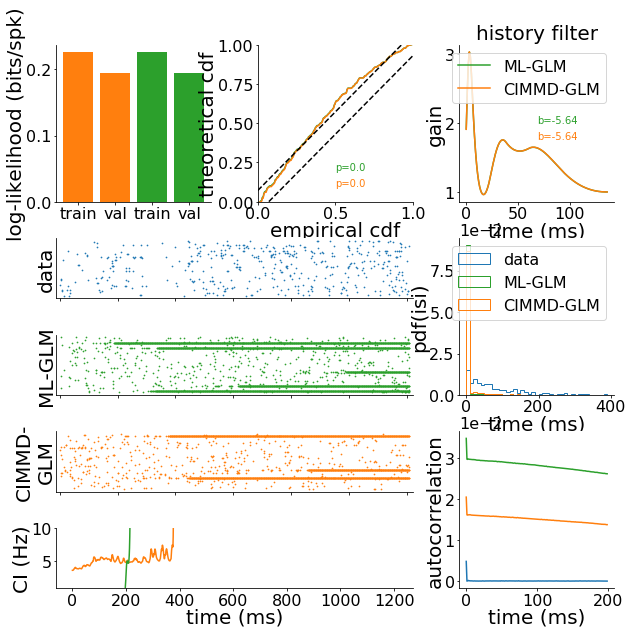

In [44]:
fig, (ax00, ax01, ax02, ax10, ax11, ax20, ax30, ax31, ax40) = plot_layout2()
fig.subplots_adjust(hspace=0.6, wspace=0.3)
# fig.suptitle('Monkey-PMv', fontsize=16, y=0.92)

ax00.bar(0, -nll_normed_train_mmd[-1], color=palette['mmd'], label='CIMMD-GLM')
ax00.bar(1, -nll_normed_val_mmd, color=palette['mmd'], label='CIMMD-GLM')
ax00.bar(2, -nll_normed_train_ml[-1], color=palette['ml'], label='ML-GLM')
ax00.bar(3, -nll_normed_val_ml[-1], color=palette['ml'], label='ML-GLM')
ax00.set_ylabel('log-likelihood (bits/spk)')
ax00.set_xticks([0, 1, 2, 3])
# ax00.set_xticklabels(['CIMMD-GLM', 'ML-GLM'])
ax00.set_xticklabels(['train', 'val', 'train', 'val'])

ax01.plot(bins_ks, z_cum_ml_val, color=palette['ml'], label='ML-GLM')
ax01.plot(bins_ks, z_cum_mmd_val, color=palette['mmd'], label='CIMMD-GLM')
x = np.array([0, 1])
ax01.plot(x, x + 1.36 / np.sqrt(len(np.concatenate((z_mmd_val)))), 'k--')
ax01.plot(x, x - 1.36 / np.sqrt(len(np.concatenate((z_mmd_val)))), 'k--')
myplt.set_labels(ax01, xlabel='empirical cdf', ylabel='theoretical cdf')
ax01.set_xlim(0, 1); ax01.set_ylim(0, 1)
ax01.text(0.5, 0.2, 'p=' + str(np.round(ks_ml_val[1], 2)), color=palette['ml'], transform=ax01.transAxes)
ax01.text(0.5, 0.1, 'p=' + str(np.round(ks_mmd_val[1], 2)), color=palette['mmd'], transform=ax01.transAxes)

glm.eta.plot(t=t_ker, ax=ax02, exp_values=True, label='ML-GLM', color=palette['ml'])
mmdglm.eta.plot(t=t_ker, ax=ax02, exp_values=True, label='CIMMD-GLM', color=palette['mmd'])
myplt.set_labels(ax02, xlabel='time (ms)', ylabel='gain', title='history filter')
ax02.text(0.5, 0.5, 'b=' + str(np.round(glm.u0, 2)), color=palette['ml'], transform=ax02.transAxes)
ax02.text(0.5, 0.4, 'b=' + str(np.round(mmdglm.u0, 2)), color=palette['mmd'], transform=ax02.transAxes)
ax02.legend()
# ax02.set_ylim(-0.4, 0.2)

st_val.plot(ax=ax10, ms=0.7, color=palette['d'])
ax10.tick_params(axis='both', labelbottom=False, labelleft=False)
ax10.set_yticks([])
ax10.set_ylabel('data')

st_fr_ml.plot(ax=ax20, ms=0.7, color=palette['ml'])
ax20.tick_params(axis='both', labelbottom=False, labelleft=False)
ax20.set_yticks([])
ax20.set_ylabel('ML-GLM')

lw = 1
ax11.hist(isi_val, density=True, alpha=1, color=palette['d'], histtype='step', lw=lw, label='data', bins=bins_isi)
ax11.hist(isi_fr_ml, density=True, alpha=1, color=palette['ml'], histtype='step', lw=lw, label='ML-GLM', bins=bins_isi)
ax11.hist(isi_fr_mmd, density=True, alpha=1, color=palette['mmd'], histtype='step', lw=lw, label='CIMMD-GLM', bins=bins_isi)
ax11.set_ylabel('pdf(isi)')
ax11.set_xlabel('time (ms)')
ax11.legend()
ax11.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

st_fr_mmd.plot(ax=ax30, ms=0.7, color=palette['mmd'])
ax30.tick_params(axis='both', labelbottom=False, labelleft=False)
ax30.set_yticks([])
ax30.set_ylabel('CIMMD-\nGLM')

argf = 200
ax31.plot(autocov_train[:argf], color=palette['d'], label='data')
ax31.plot(autocov_ml[:argf], color=palette['ml'], label='ML-GLM')
ax31.plot(autocov_mmd[:argf], color=palette['mmd'], label='CIMMD-GLM')
# ax31.set_ylim(0, 5e-3)
myplt.set_labels(ax31, xlabel='time (ms)', ylabel='autocorrelation')
ax31.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

alpha = 1
ax40.plot(t, np.mean(r_fr_mmd, 1), alpha=alpha, color=palette['mmd'], label='fr')
ax40.plot(t, np.mean(r_fr_ml, 1), alpha=alpha, color=palette['ml'], label='fr')
# ax40.legend()
ax40.set_ylim(0.8, 1e1)
myplt.set_labels(ax40, xlabel='time (ms)', ylabel='CI (Hz)')

fig.savefig('/home/diego/Dropbox/generative_glm/figures/fig4.pdf', transparent=True)